# Textual Inversion with Determined

This notebook generates images from the trained textual inversion models generated with the `detsd.DetStableDiffusionTITrainer` class and saved as Determined checkpoints.  This notebook should be connected to a GPU.

### Pre-Launch Setup

A [Huggingface User Access Token](https://huggingface.co/docs/hub/security-tokens) is required to download the [Stable Diffusion weights](https://huggingface.co/CompVis/stable-diffusion-v1-4). To use this notebook, please modify the following lines in the `detsd-notebook.yaml` file:
```yaml
environment:
    environment_variables:
        - HF_AUTH_TOKEN=YOUR_HF_AUTH_TOKEN_HERE
```
after which this notebook can be launched by calling the below from the root of the repo directory
```bash
det -m MASTER_URL_WITH_PORT notebook start --config detsd-notebook.yaml --context .
```
and then opening up the copy of `textual_inversion.ipynb` on the master.
**TODO: Update `--context` arg, don't pull in whole repo unnecessarily**

Update the jupyter notebook for better progress-bar rendering. Assuming the notebook has dependencies have already been installed via `startup-hook.sh`, which is run upon agent start-up.

In [1]:
! pip install -qq jupyterlab-widgets==1.1.1 ipywidgets==7.7.2

Import the `DetSDTextualInversionPipeline` class from `detsd.py` (loaded via the `--context flag above), which will be used to generate Stable Diffusion images.

In [ ]:
from detsd import DetSDTextualInversionPipeline

In [ ]:
# Code for logging into the master, if not already logged in.
# Not required if notebook was launched as described above.
# client.login(master: MASTER_URL, user: USER, password: PASS)

## Load Determined Checkpoints

We will now construct the `DetSDTextualInversionPipeline`, incorporating into the model any textual-inversion checkpoints we have trained with `DetStableDiffusionTITrainer`, also contained in `detsd.py`.  These Determined checkpoints can be specified by their uuid, assuming all such checkpoints exist on the master we are currently logged into.

In [11]:
uuids = ['b8e4e741-a770-4359-a301-679b86e5f1f2']
detsd_pipeline = DetSDTextualInversionPipeline.from_uuids(uuids,)

['learned_embeds.pt', 'metadata.json', 'optimizer_state_dict.pt']

The above pipeline was constructed using the default settings. In particular, it uses the default `fp16=True` and `autocast=True` options which are used to increase inference speed and reduce memory usage, at the cost of somewhat reduced-quality images.  Other available args are listed below

In [ ]:
? DetSDTextualInversionPipeline.from_uuids

If you have not trained any textual inversion checkpoints and simply want to generate images using the original Stable Diffusion model without custom concepts added, you can leave the `uuids` list below empty or alternatively instantiate the pipeline via
```python
detsd_pipeline = DetSDTextualInversionPipeline()
```
which uses the same default arguments as above.

## Generate Images

Images can be generated by calling our `detsd_pipeline` instance as in the below:

In [ ]:
# Create a directory in which to save the generated images:
! mkdir generated_images

In [ ]:
imgs = detsd_pipeline(prompt='a photograph of an astronaut on a horse',
                      parallelize_factor=2,
                      rows=2,
                      cols=2,
                      num_inference_steps=50,
                      seed=2147483647,
                      guidance_scale=7.5,
                      saved_img_dir='generated_images')

An explanation of the most important arguments above:
* `prompt`: the prompt string which will be used to generate images
* `num_inference_steps`: how many steps to run the generation process for. ~50 is typical
* `guidance_scale`: knob for tuning how much weight is given to the prompt during generation. 7.5 is the default, with larger numbers giving stronger weight to the prompt.
* `generator_seed`: fixed RNG seed for reproducibility

See the [Hugging Face documentation](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion#diffusers.StableDiffusionPipeline.__call__) for further information on the available arguments.

Create images! A fixed `generator` is used for reproducibility.  Fiddle with the seed for additional variation.

In [ ]:
?pipeline.text_encoder.add_tokens

In [ ]:
placeholder_tokens = checkpoint_metadata_dict['placeholder_tokens']
prompt = f'a watercolor painting of a {placeholder_tokens[0]}, soft colors, pastels, masterpiece, incredible composition'
num_inference_steps = 45
guidance_scale = 7.5
generator_seed = 2147483630

In [15]:
! mkdir generated_images

0it [00:00, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


0it [00:00, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


0it [00:00, ?it/s]

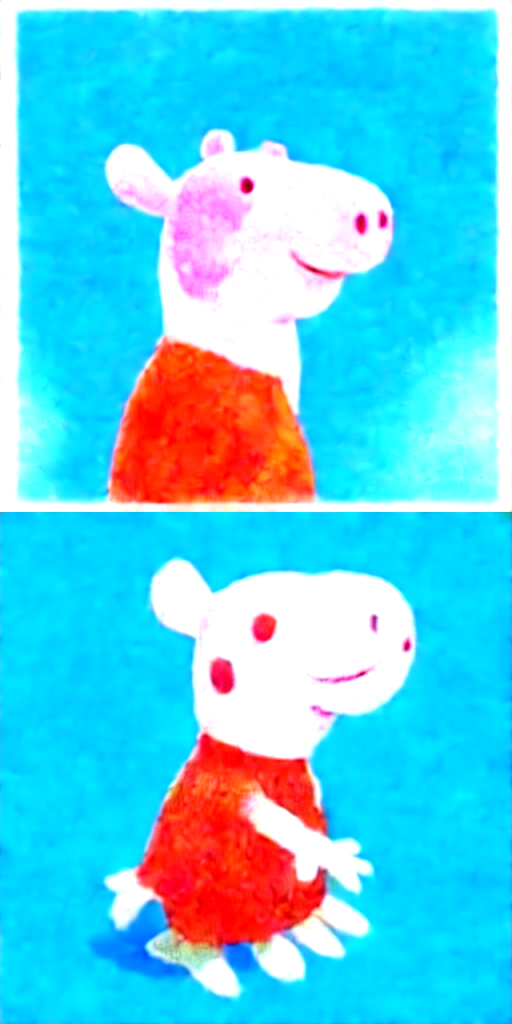

In [16]:
image_grid = pipeline(prompt,
                      parallelize_factor=2,
                      rows=2,
                      cols=1,
                      num_inference_steps=num_inference_steps,
                      generator_seed=generator_seed,
                      guidance_scale=guidance_scale,
                      saved_img_dir='generated_images')
image_grid

In [ ]:
for steps in range(30, 60, 5):
    for scale in range(0, 20, 2):
        for seed in range(generator_seed, generator_seed + 20):
            image_grid = pipeline(prompt,
                                  parallelize_factor=2,
                                  rows=2,
                                  cols=2,
                                  num_inference_steps=steps,
                                  generator_seed=seed,
                                  guidance_scale=5. + scale,
                                  saved_img_dir='generated_images')